In [1]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import DeepEnsemble
import metrics

In [2]:
data_dir = 'data/q_photo_z_train'
with open(f'{data_dir}/feature_lists/features_sdssdr16+all_deacls8tr_QSO+GALAXY_20201212143658.pkl', 'rb') as f:
    features_20 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_35 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_deacls8tr_QSO+GALAXY_20201212135641.pkl', 'rb') as f:
    features_21 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_psdr2+all_deacls8tr_QSO+GALAXY_20201212142333.pkl', 'rb') as f:
    features_22 = pickle.load(f)
np.random.seed(2)
torch.manual_seed(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_01 = pd.read_csv(f'{data_dir}/train_01.csv')
train_02 = pd.read_csv(f'{data_dir}/train_02.csv')

In [4]:
train_01.shape, train_02.shape

((290456, 68), (290456, 68))

In [5]:
train_01

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z
0,24.196261,-10.109838,-0.011447,20.842147,19.756733,19.267105,19.053641,18.921812,20.784370,19.059832,...,20.097554,19.708072,19.182611,18.952056,0.525462,0.756016,0.230554,0.046929,0.077926,-0.039920
1,184.240161,0.634044,-0.007947,19.550209,18.671965,18.413090,18.318118,18.306308,19.526882,18.314960,...,19.986535,18.620714,18.362966,18.315778,0.257748,0.304936,0.047188,0.029889,0.037541,-0.058617
2,18.832807,25.355562,-0.002058,19.957126,19.084415,18.829452,18.737669,18.721188,19.828226,18.745945,...,21.255445,19.100432,18.798307,18.728667,0.302125,0.371765,0.069640,-0.010383,0.020552,-0.026118
3,340.711120,27.224917,-0.000798,24.037264,24.393690,24.110717,22.260261,21.029142,22.646628,21.899228,...,19.750499,23.207197,22.253819,21.436077,0.953378,1.771120,0.817742,-2.455154,-3.431797,-1.056814
4,260.933195,31.721459,-0.000673,22.848628,20.353622,19.230868,18.332436,22.256517,22.544334,18.610944,...,21.668436,21.513445,20.807325,20.516810,0.706121,0.996636,0.290515,-0.864768,-0.724820,1.085615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290451,17.471379,-30.790642,6.790900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.119738,27.057384,26.413516,22.235233,0.643868,4.822150,4.178282,NaN,NaN,NaN
290452,62.869291,-9.130500,6.810000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.371833,26.801125,27.737346,20.688208,-0.936220,6.112917,7.049137,NaN,NaN,NaN
290453,5.131124,-36.894948,6.834000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.699577,26.872133,25.794745,21.392132,1.077387,5.480001,4.402613,NaN,NaN,NaN
290454,41.732917,-52.330528,6.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.398229,26.798456,26.429906,21.943340,0.368550,4.855116,4.486566,NaN,NaN,NaN


In [6]:
train_02

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z
0,170.455790,19.878579,-0.009112,21.240596,19.528449,18.831749,18.584223,18.425744,21.187583,18.583677,...,20.199544,19.441993,18.753491,18.437092,0.688502,1.004902,0.316399,0.087280,0.072679,-0.037778
1,122.091429,30.926546,-0.005114,22.468104,21.251481,20.282878,20.080934,19.888133,19.921550,19.986937,...,20.341554,21.105814,20.244741,19.799577,0.861072,1.306237,0.445164,0.154109,0.027697,0.031030
2,147.244138,27.849499,-0.000810,22.761290,21.715669,21.760738,21.599708,22.067579,21.701000,21.575285,...,21.209581,21.861513,21.793569,21.934405,0.067944,-0.072891,-0.140835,-0.120718,-0.109615,-2.930384
3,257.835533,37.789509,-0.000705,24.357430,21.330316,20.575749,20.366500,20.312108,22.702280,20.404416,...,22.130455,21.154559,20.462977,20.144698,0.691582,1.009862,0.318279,0.175621,0.120504,0.120755
4,25.663676,31.955126,-0.000623,23.771979,20.908762,20.231773,19.842709,19.725892,21.474170,19.900056,...,22.423764,20.817729,20.078264,19.689787,0.739464,1.127942,0.388477,0.063125,0.168922,0.093665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290451,174.891806,49.894562,6.795398,24.230143,24.980301,23.235294,22.281788,20.942590,20.276665,20.934541,...,19.300962,23.706961,22.230237,20.638693,1.476724,3.068268,1.591544,-1.142203,0.614252,-0.436247
290452,49.923583,-10.146111,6.830000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.398678,27.705025,26.689694,22.043740,1.015331,5.661285,4.645954,NaN,NaN,NaN
290453,332.752500,-63.348833,6.880000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.809688,26.352327,26.148593,22.404706,0.203734,3.947620,3.743886,NaN,NaN,NaN
290454,129.945333,39.003194,6.905000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.997189,25.515129,25.774839,21.035744,-0.259710,4.479385,4.739095,NaN,NaN,NaN


In [7]:
t_01 = train_01[['RA', 'DEC', 'Z'] + features_35].dropna().reset_index()
X_01 = t_01[features_35].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_02[['RA', 'DEC', 'Z'] + features_35].dropna().reset_index()
X_02 = t_02[features_35].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

In [8]:
t_01.shape, t_02.shape

((288201, 69), (288221, 69))

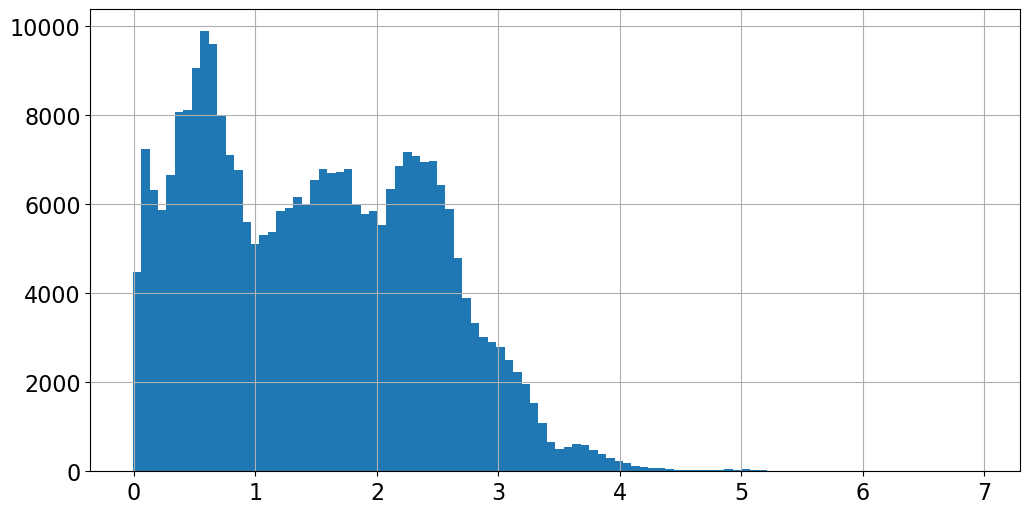

In [9]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()
plt.hist(y_01, bins=100);

In [10]:
# def p_func(z):
#     return 1 / (1 + np.exp(-4*(z-5)))
# n_dup = 200
# z_thr = 4.5

# dataloader = DeepEnsemble.HZ_dataloader_new(
#     torch.tensor(X_01, device=torch.device(device), dtype=torch.float),
#     torch.tensor(y_01, device=torch.device(device), dtype=torch.float), 
#     p_func, n_dup, z_thr=5, batch_size=2**13, shuffle=False, device=device
# )

# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 6))
# plt.grid()
# plt.hist(y_01[dataloader.all_idx.cpu().numpy()], bins=100);

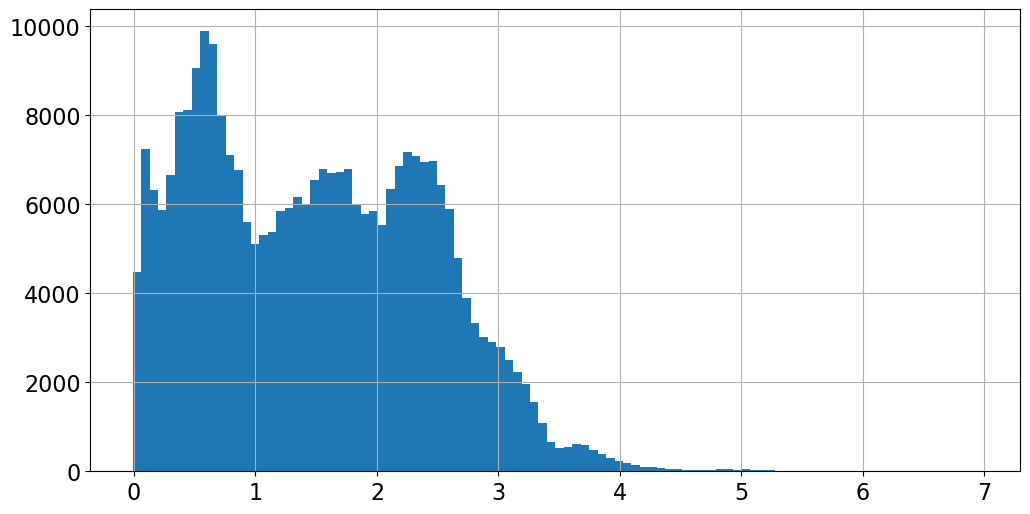

In [11]:
def p_func(z):
    return 1 / (1 + np.exp(-2.4*(z-6))) + 0.0002*np.exp((-6)*(z-1)**2) + 0.0002*np.exp((-3)*(z-2)**2)
n_dup = 1
z_thr = 4.5

dataloader = DeepEnsemble.HZ_dataloader_new(
    torch.tensor(X_01, device=torch.device(device), dtype=torch.float),
    torch.tensor(y_01, device=torch.device(device), dtype=torch.float), 
    p_func, n_dup, z_thr=5, batch_size=2**13, shuffle=False, device=device
)

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()
plt.hist(y_01[dataloader.all_idx.cpu().numpy()], bins=100);

In [12]:
# def p_func(z):
#     return 0

Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.17592, -1.24435, -1.25597, -1.22015, -1.26331]
AVG train loss: -1.23194
Train S_nmad: 0.02335	Train out_rate: 0.03345	Train S_nmad_z5: 0.04256	Train out_rate_z5: 0.1097	
----------------------------------------
Test losses: [-1.02362, -1.04918, -1.05014, -1.01629, -1.03786]
AVG test loss: -1.03542
Test S_nmad: 0.02787	Test out_rate: 0.04031	Test S_nmad_z5: 0.05715	Test out_rate_z5: 0.17593	
----------------------------------------
Time: 2.018


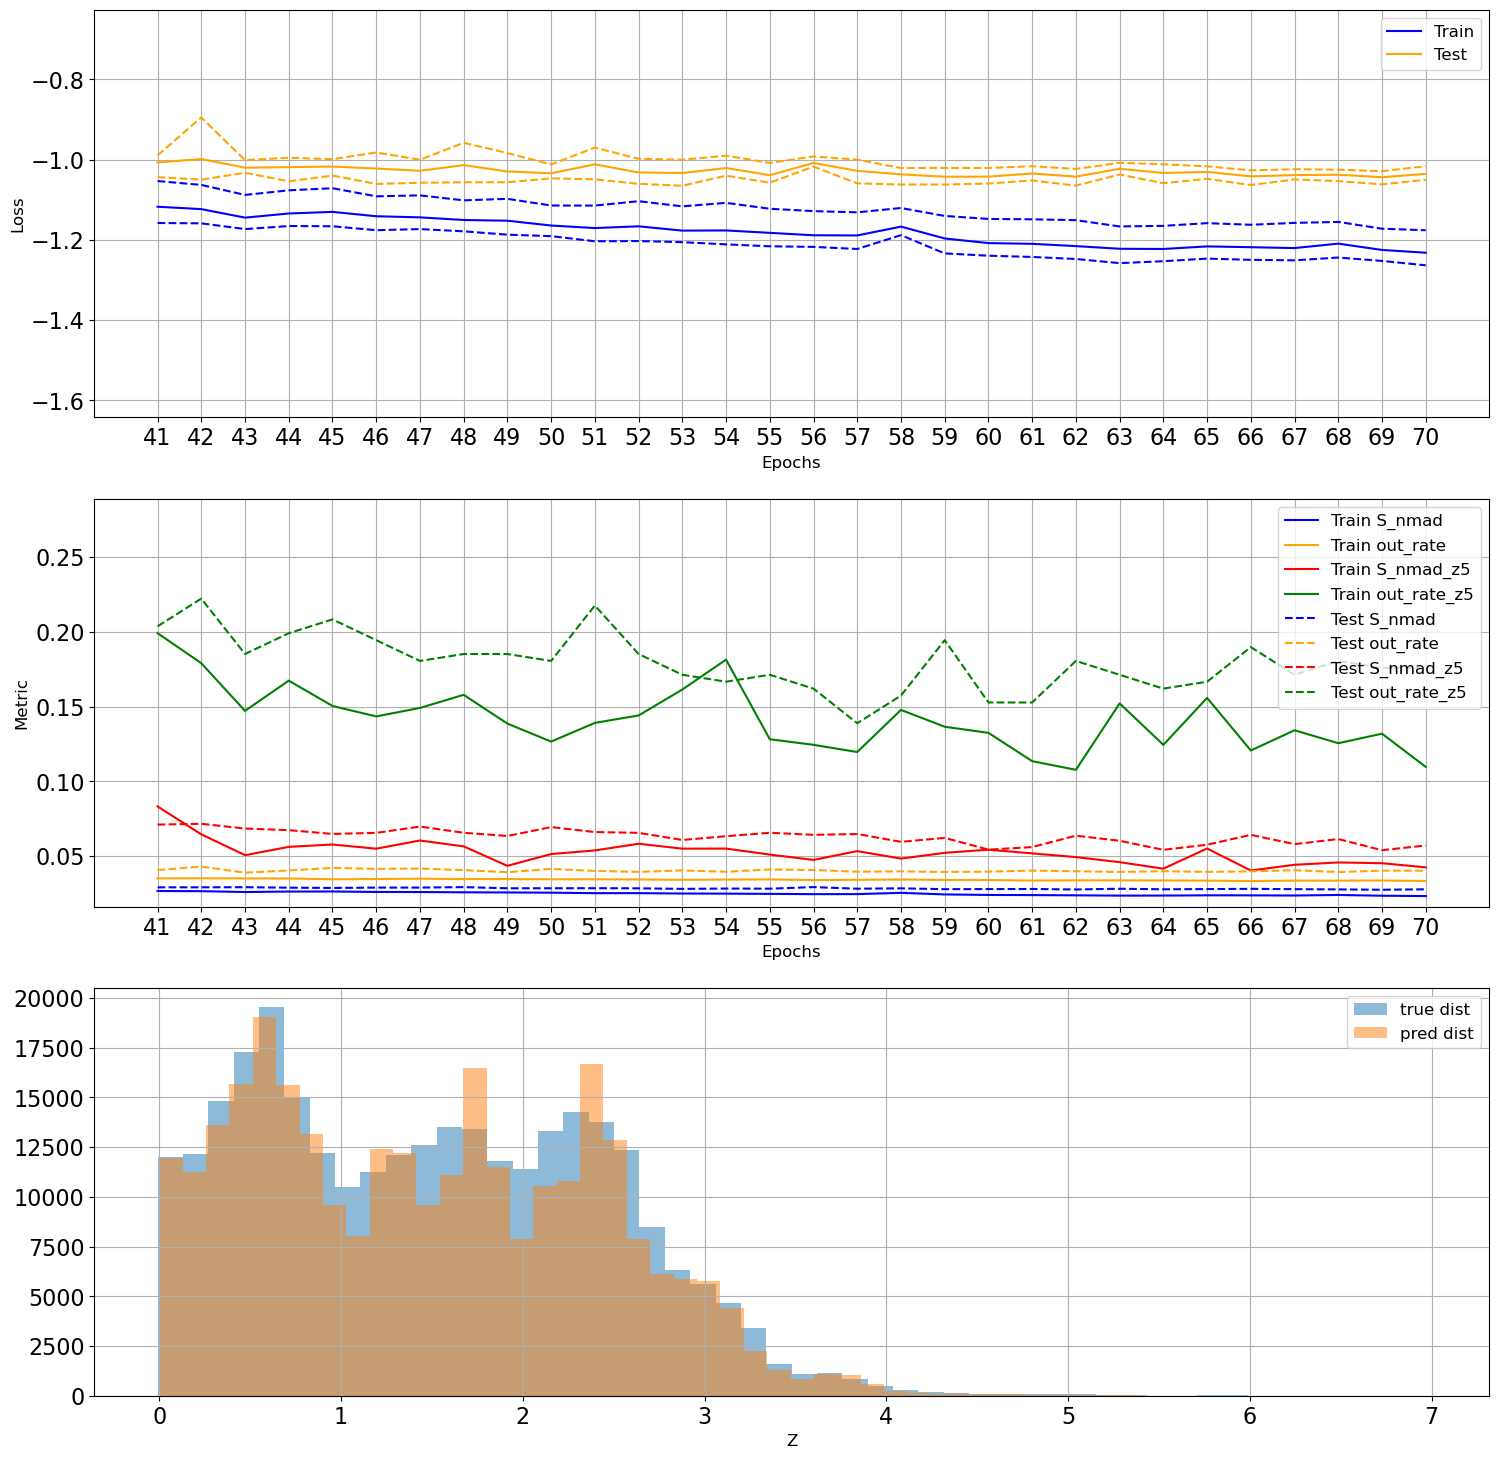

In [13]:
np.random.seed(1)
torch.manual_seed(1)

ens_35_01 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, 3], 'p': 0.0},
    5, device
)

X_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_35_01.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=70, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

In [14]:
result_35_02 = ens_35_01.predict(X_02)
result_35_02 = pd.concat([t_02[['RA', 'DEC', 'Z']], result_35_02], axis=1)
result_35_02

,RA,DEC,Z,pi_00,pi_01,pi_02,pi_03,pi_04,pi_05,pi_06,...,sample_279,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf
0,170.455790,19.878579,-0.009112,2.505201e-03,0.183837,0.013658,0.135863,0.043333,0.020804,0.007192,...,2.941755,0.238953,2.637986,2.974190,2.076335,-0.210804,0.251370,1.615189,0.712709,0.184028
1,122.091429,30.926546,-0.005114,1.399796e-09,0.186935,0.013065,0.057674,0.136438,0.005888,0.146782,...,3.799653,0.327460,1.595282,3.035741,0.424347,1.864059,2.478956,0.036591,1.557045,0.732639
2,147.244138,27.849499,-0.000810,2.874685e-11,0.198087,0.001913,0.000544,0.194548,0.004907,0.196156,...,2.638384,2.514634,2.129545,2.148068,2.207166,2.698320,2.612791,2.712051,3.028439,0.961806
3,257.835533,37.789509,-0.000705,4.765570e-08,0.195538,0.004462,0.109205,0.006936,0.083860,0.000473,...,0.011929,2.127794,0.113438,3.030386,3.019184,1.383569,3.020591,1.531124,0.198649,0.142361
4,25.663676,31.955126,-0.000623,3.528581e-09,0.161707,0.038293,0.181434,0.016503,0.002064,0.001806,...,1.339255,0.931404,3.321282,0.405999,0.145449,1.223075,2.810730,0.975996,0.519949,0.201389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288216,193.777745,47.962373,6.445232,1.900470e-05,0.009595,0.190386,0.021937,0.000462,0.177601,0.001271,...,0.394392,0.565557,0.470300,0.480514,0.458508,0.489320,0.586143,0.437776,0.415705,0.836806
288217,247.297067,24.127706,6.476000,3.925772e-05,0.198843,0.001118,0.199925,0.000074,0.000001,0.010818,...,4.635305,5.529865,3.732010,5.006724,5.649306,-1.773242,4.717325,0.137599,5.165919,0.920139
288218,36.507807,3.049838,6.541200,7.910195e-04,0.184111,0.015098,0.189927,0.010064,0.000009,0.072173,...,5.630438,3.471651,3.224993,1.551758,5.428335,1.738008,4.396379,5.522761,4.998416,0.843750
288219,174.891806,49.894562,6.795398,2.408512e-04,0.001809,0.197950,0.082384,0.001973,0.115643,0.003329,...,0.896282,0.777032,0.709468,0.936163,0.665698,0.775713,0.697001,0.780046,0.798886,0.736111


Device: cuda
Test mode: True
EPOCH #70/70:
Learning rate: 5.98e-05
----------------------------------------
Trian losses: [-1.15081, -1.22078, -1.21849, -0.96344, -1.221]
AVG train loss: -1.1549
Train S_nmad: 0.02448	Train out_rate: 0.03447	Train S_nmad_z5: 0.0538	Train out_rate_z5: 0.07252	
----------------------------------------
Test losses: [-1.02316, -1.02708, -1.04905, -0.88374, -1.03451]
AVG test loss: -1.00351
Test S_nmad: 0.02818	Test out_rate: 0.04164	Test S_nmad_z5: 0.05389	Test out_rate_z5: 0.14136	
----------------------------------------
Time: 1.952


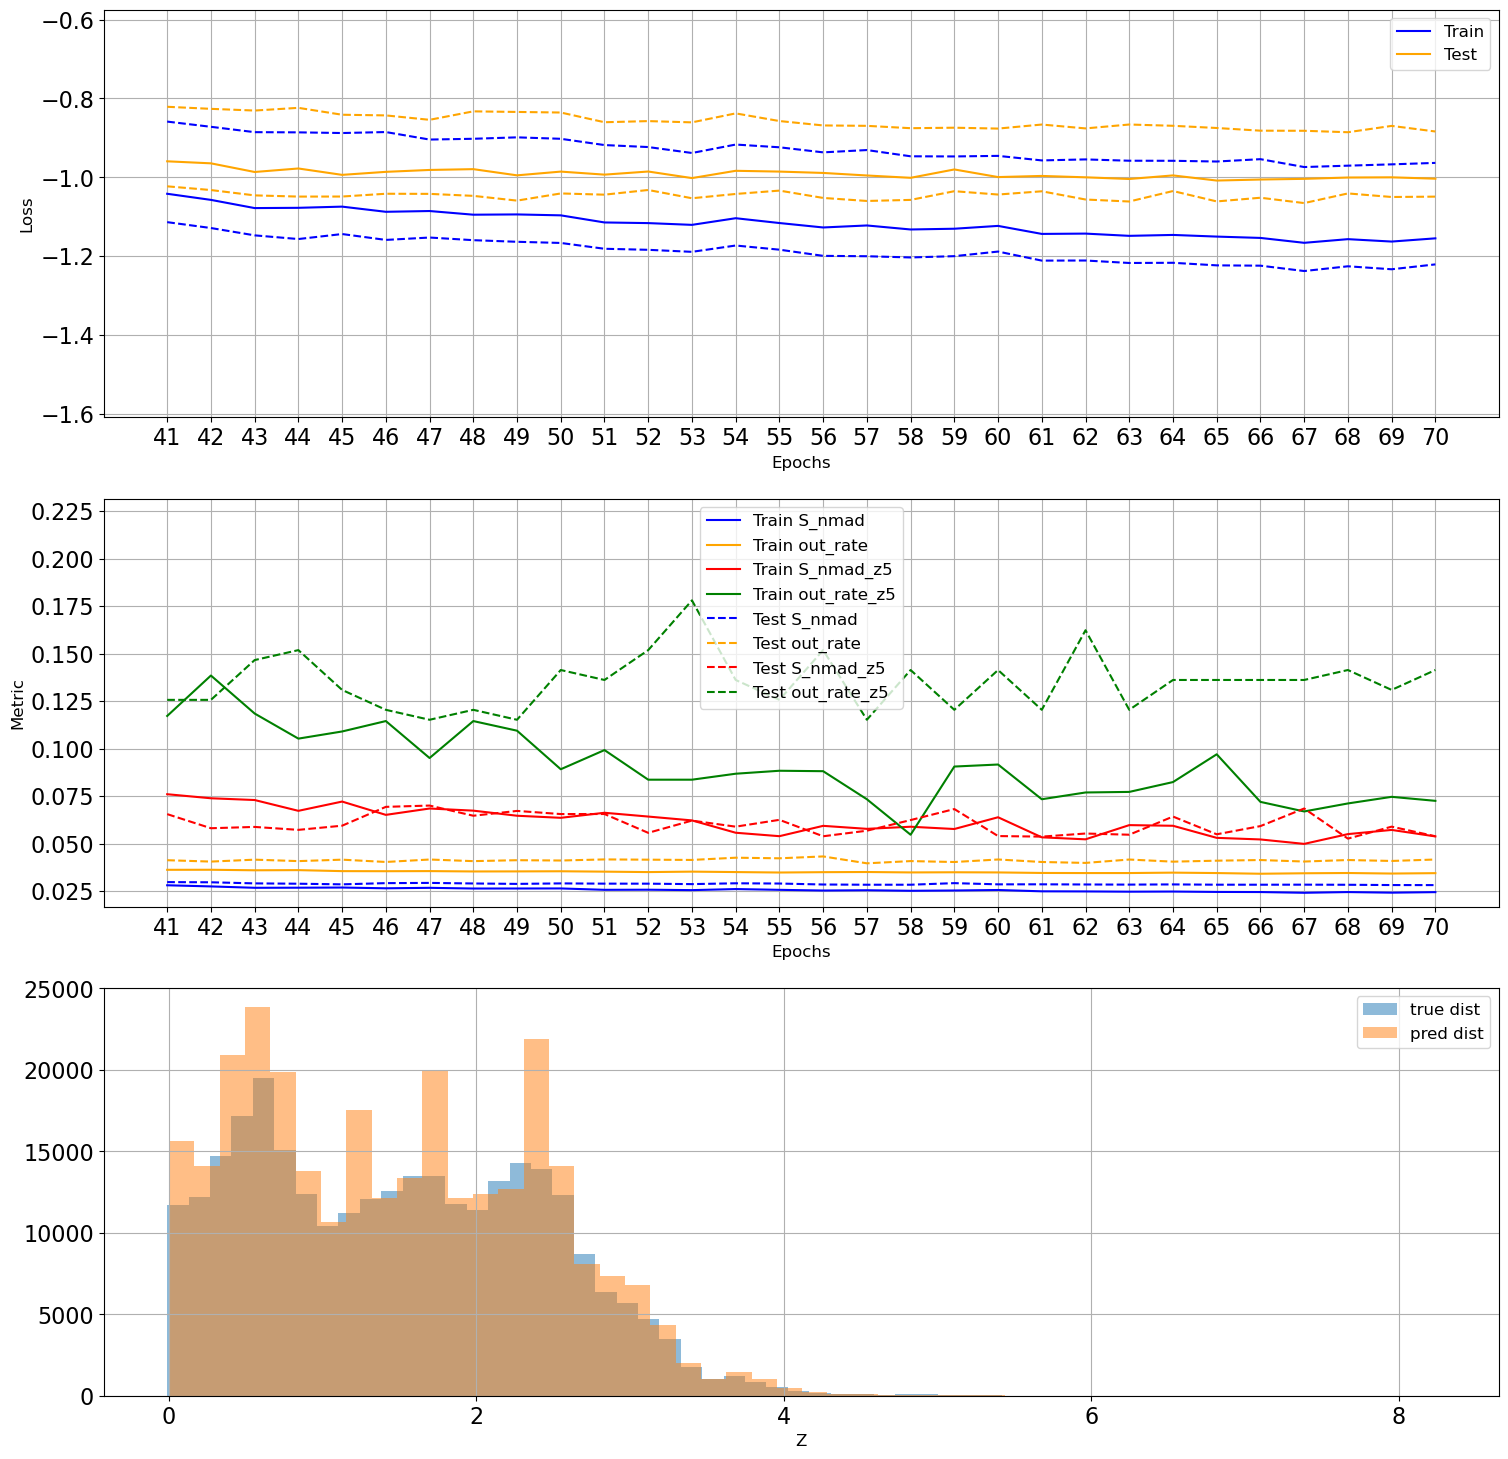

In [15]:
np.random.seed(1)
torch.manual_seed(1)

ens_35_02 = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MLP_GMM, 
    {'sizes': [X_02.shape[1], 400, 400, 400, 400, 400, 400, 3], 'p': 0.0},
    5, device
)

X_train_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)
X_test_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens_35_02.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_new,
    train_dataloader_params={
        'X': X_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloader,
    test_dataloader_params={
        'X': X_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=70, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

In [16]:
result_35_01 = ens_35_02.predict(X_01)
result_35_01 = pd.concat([t_01[['RA', 'DEC', 'Z']], result_35_01], axis=1)
result_35_01

,RA,DEC,Z,pi_00,pi_01,pi_02,pi_03,pi_04,pi_05,pi_06,...,sample_279,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf
0,24.196261,-10.109838,-0.011447,3.518617e-03,0.180640,1.584091e-02,1.083767e-02,1.843366e-01,4.825747e-03,8.700235e-03,...,2.282831,1.840644,1.055448,2.968720,0.514200,1.425461,1.390676,0.287009,2.782908,0.211806
1,184.240161,0.634044,-0.007947,2.272833e-04,0.182220,1.755297e-02,6.790059e-04,1.966953e-01,2.625688e-03,1.157578e-01,...,1.118889,3.500639,2.425999,2.210162,0.591084,1.378095,0.353727,2.605617,1.499652,0.607639
2,18.832807,25.355562,-0.002058,7.702222e-11,0.199972,2.830028e-05,2.634114e-07,1.995057e-01,4.940679e-04,3.339452e-04,...,2.363588,1.860526,0.247706,1.529038,2.957716,1.583375,0.112517,3.104782,1.125068,0.128472
3,340.711120,27.224917,-0.000798,2.000000e-11,0.200000,2.046585e-11,2.000000e-11,4.631787e-03,1.953682e-01,1.657045e-06,...,0.537306,0.874793,0.600944,1.083665,-1.893323,0.409944,-0.109246,3.213328,0.419056,0.402778
4,184.390621,12.388094,-0.000515,2.000000e-11,0.199995,5.268734e-06,2.000000e-11,1.378318e-09,2.000000e-01,3.412030e-10,...,-0.033874,0.000418,0.032139,0.005470,0.016434,-0.021271,0.022992,0.003489,-0.004532,0.993056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288196,15.054263,28.040532,6.325800,2.000277e-11,0.199996,4.420687e-06,2.000000e-11,2.000000e-01,2.931453e-09,4.583301e-06,...,-0.227834,5.036529,7.765520,8.601416,5.447141,7.898431,2.283347,6.545032,6.588992,0.670139
288197,170.832667,20.208275,6.410000,3.082139e-09,0.197709,2.291091e-03,2.754447e-11,1.975151e-01,2.484872e-03,2.857453e-04,...,0.287949,3.713915,4.384427,0.469889,1.089742,0.650707,2.203682,3.459090,2.657396,0.322917
288198,177.069376,52.863999,6.418900,5.040157e-10,0.175491,2.450897e-02,2.000010e-11,1.999953e-01,4.687112e-06,6.471684e-03,...,6.880753,3.393111,5.996927,7.934234,5.972661,5.275051,2.266697,6.367910,5.678450,0.774306
288199,16.619326,18.475668,6.578712,1.999423e-01,0.000015,4.272452e-05,4.809049e-03,1.933805e-01,1.810460e-03,1.993869e-01,...,1.948312,0.805982,2.096385,1.952088,2.029282,2.171107,2.061698,2.051308,2.046018,0.993056


In [17]:
result_35 = pd.concat([result_35_01, result_35_02])
result_35.sort_values(by=['Z'], inplace=True)
result_35.reset_index(drop=True, inplace=True)
result_35

,RA,DEC,Z,pi_00,pi_01,pi_02,pi_03,pi_04,pi_05,pi_06,...,sample_279,sample_280,sample_281,sample_282,sample_283,sample_284,sample_285,sample_286,sample_287,zConf
0,24.196261,-10.109838,-0.011447,3.518617e-03,0.180640,0.015841,1.083767e-02,0.184337,0.004826,0.008700,...,2.282831,1.840644,1.055448,2.968720,0.514200,1.425461,1.390676,0.287009,2.782908,0.211806
1,170.455790,19.878579,-0.009112,2.505201e-03,0.183837,0.013658,1.358629e-01,0.043333,0.020804,0.007192,...,2.941755,0.238953,2.637986,2.974190,2.076335,-0.210804,0.251370,1.615189,0.712709,0.184028
2,184.240161,0.634044,-0.007947,2.272833e-04,0.182220,0.017553,6.790059e-04,0.196695,0.002626,0.115758,...,1.118889,3.500639,2.425999,2.210162,0.591084,1.378095,0.353727,2.605617,1.499652,0.607639
3,122.091429,30.926546,-0.005114,1.399796e-09,0.186935,0.013065,5.767391e-02,0.136438,0.005888,0.146782,...,3.799653,0.327460,1.595282,3.035741,0.424347,1.864059,2.478956,0.036591,1.557045,0.732639
4,18.832807,25.355562,-0.002058,7.702222e-11,0.199972,0.000028,2.634114e-07,0.199506,0.000494,0.000334,...,2.363588,1.860526,0.247706,1.529038,2.957716,1.583375,0.112517,3.104782,1.125068,0.128472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576417,36.507807,3.049838,6.541200,7.910195e-04,0.184111,0.015098,1.899270e-01,0.010064,0.000009,0.072173,...,5.630438,3.471651,3.224993,1.551758,5.428335,1.738008,4.396379,5.522761,4.998416,0.843750
576418,16.619326,18.475668,6.578712,1.999423e-01,0.000015,0.000043,4.809049e-03,0.193381,0.001810,0.199387,...,1.948312,0.805982,2.096385,1.952088,2.029282,2.171107,2.061698,2.051308,2.046018,0.993056
576419,174.891806,49.894562,6.795398,2.408512e-04,0.001809,0.197950,8.238391e-02,0.001973,0.115643,0.003329,...,0.896282,0.777032,0.709468,0.936163,0.665698,0.775713,0.697001,0.780046,0.798886,0.736111
576420,357.461364,6.252772,6.949000,1.178185e-01,0.000885,0.081296,1.086739e-02,0.188631,0.000502,0.189618,...,1.848165,1.880815,1.274554,1.730429,2.782527,1.600840,1.483851,1.757811,1.780279,0.750000


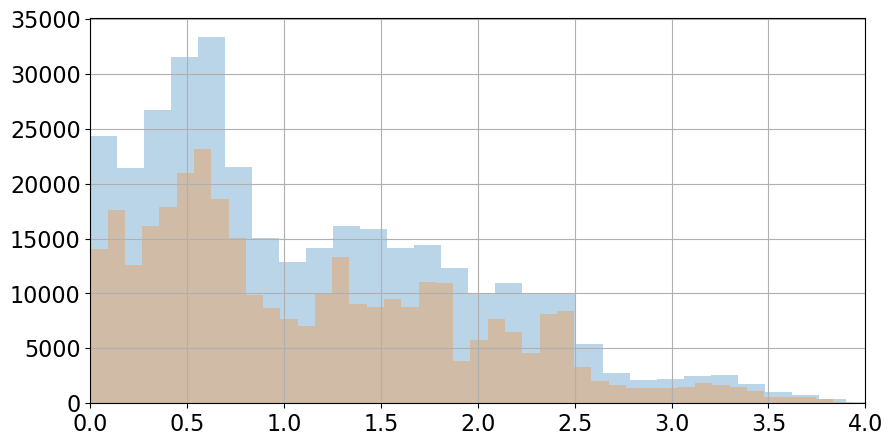

In [18]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 5))
plt.xlim(0, 4)
plt.grid()

plt.hist(result_35[result_35['sigma'] < 0.1]['Z'], bins=50, alpha=0.3)
plt.hist(result_35[result_35['sigma'] < 0.1]['mode'], bins=50, alpha=0.3);

In [19]:
len(result_35[result_35['sigma'] < 0.1]) / len(result_35)

0.5835724521270874

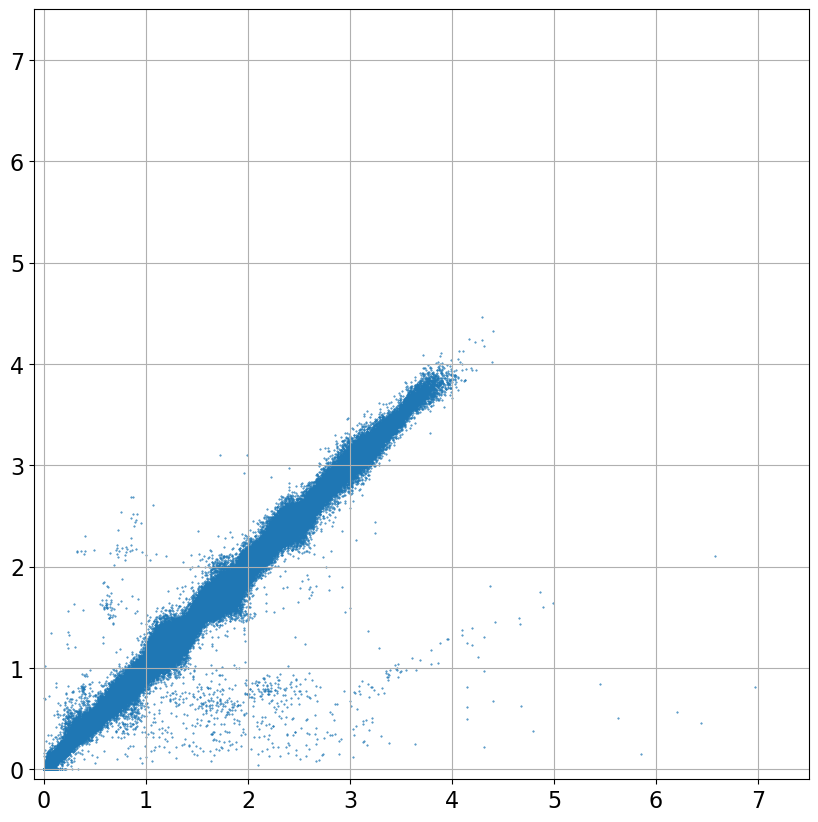

In [20]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result_35[result_35['sigma'] < 0.1]['Z'], result_35[result_35['sigma'] < 0.1]['mode'], s=0.2)

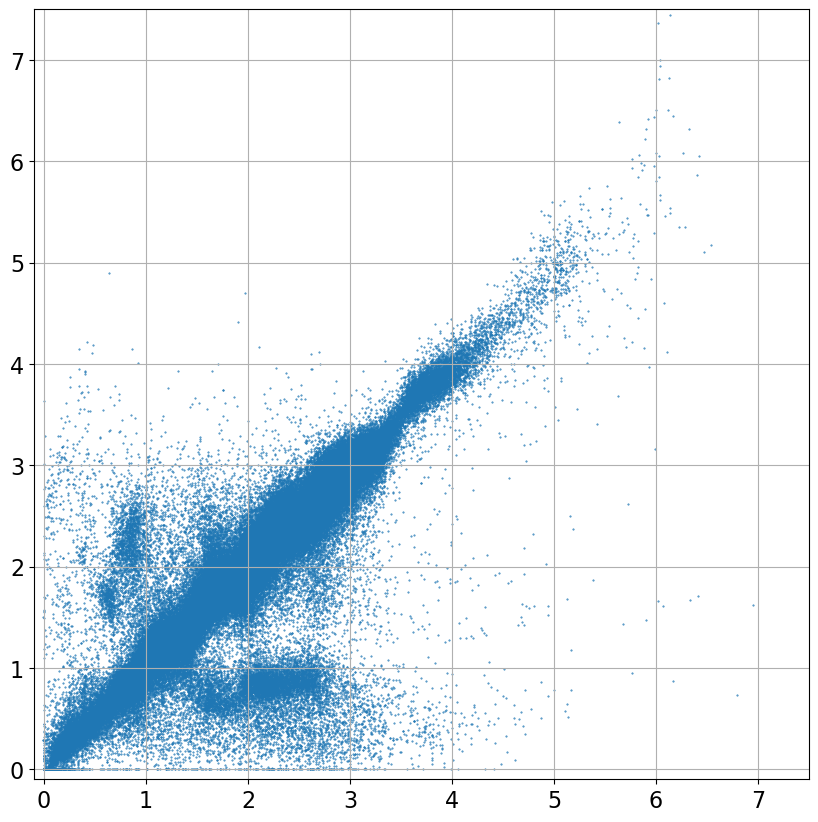

In [21]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 7.5))
plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(result_35[result_35['sigma'] > 0.1]['Z'], result_35[result_35['sigma'] > 0.1]['mode'], s=0.2)

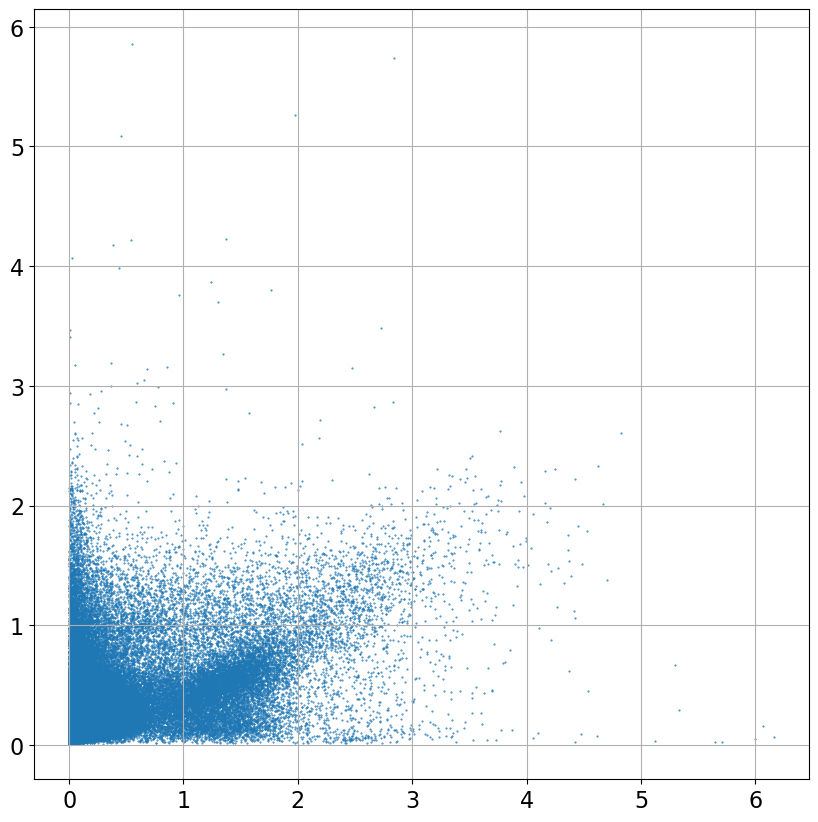

In [22]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
# plt.xlim((-0.1, 7.5))
# plt.ylim((-0.1, 7.5))
plt.grid()

plt.scatter(np.abs(result_35['Z'] - result_35['mode']), result_35['sigma'], s=0.2)

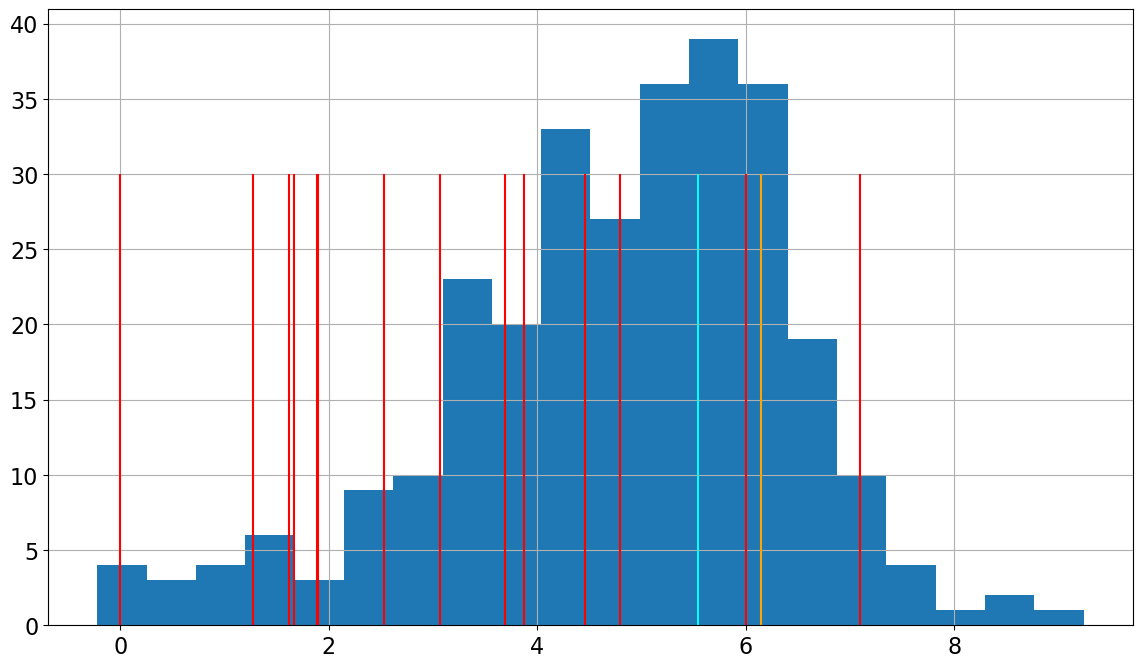

In [23]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 8))
plt.grid()

IDX = 576401
plt.hist(result_35.values[IDX, 50:], bins=20)
plt.vlines(ymin=0, ymax=30, x=result_35.values[IDX, 18:33], color='r')
plt.vlines(ymin=0, ymax=30, x=result_35.values[IDX, 48], color='cyan')
plt.vlines(ymin=0, ymax=30, x=result_35.values[IDX, 2], color='orange')

In [24]:
print(metrics.sigma_nmad(result_35['Z'], result_35['mode']))
print(metrics.out_rate(result_35['Z'], result_35['mode']))
print(metrics.sigma_nmad_z5(result_35['Z'], result_35['mode']))
print(metrics.out_rate_z5(result_35['Z'], result_35['mode']))

0.02803234939982403
0.040831196588610424
0.05441708084347851
0.15233415233415235


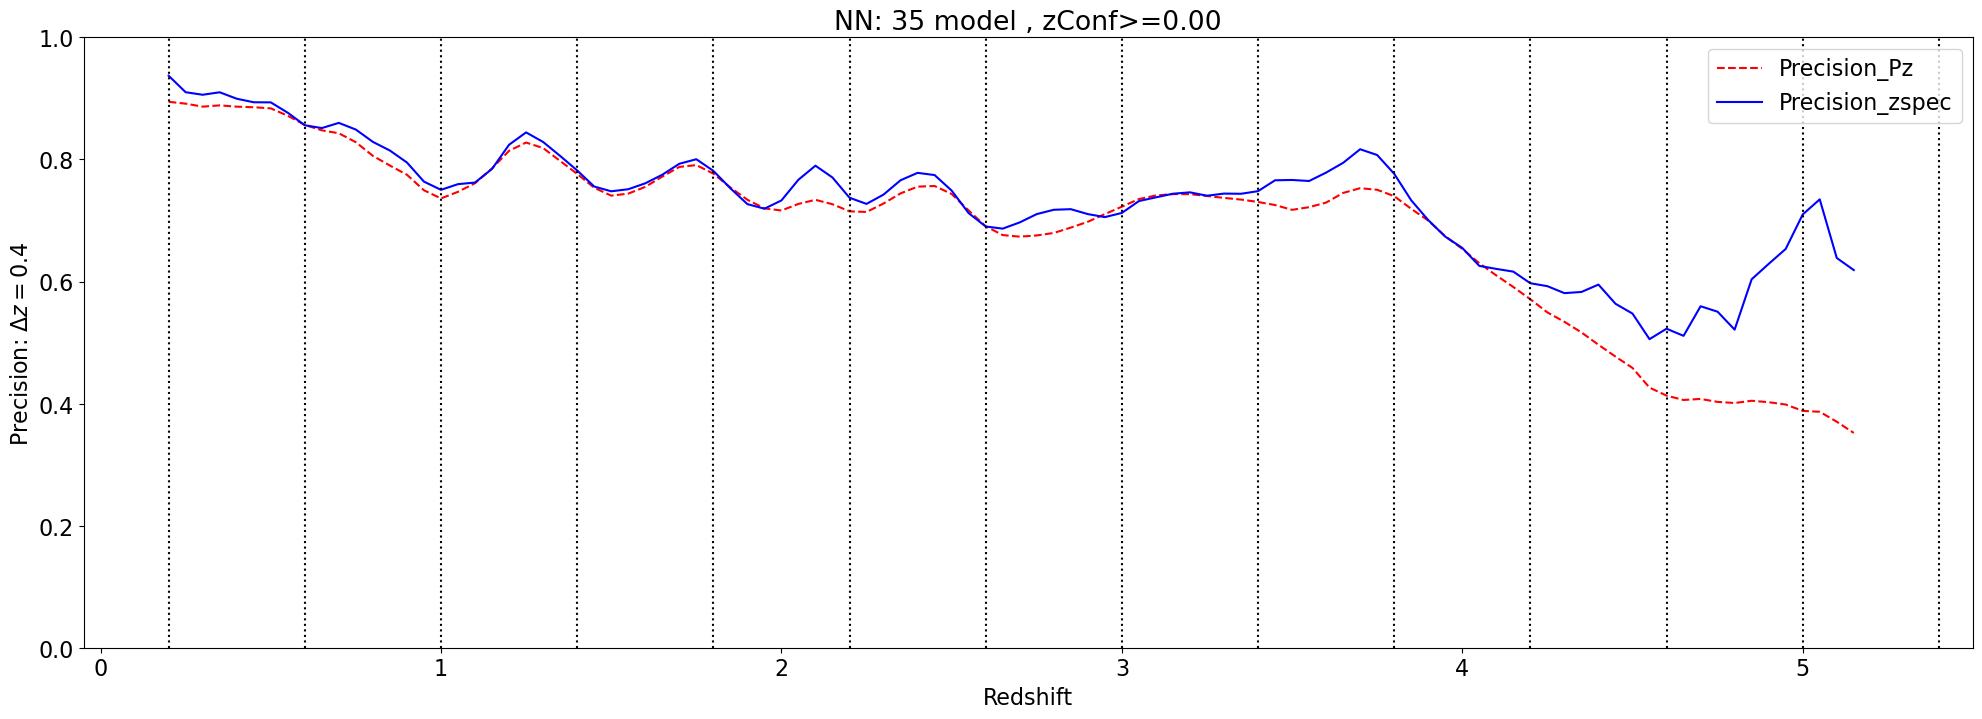

In [25]:
dz = 0.4
zC = 0.0

df = result_35

lprec = [] 
for z in np.arange(0.2, 5.2, 0.05):
    lgs = [];    

    zz = z
    z1 = zz - dz/2
    z2 = zz + dz/2
    bs = [z1,z2]
    df12 = df.loc[(df[f'mode']>=z1)&(df[f'mode']<z2),:]
    dd = pd.Series(df12.loc[:,df12.columns[50:50+288]].values.flatten())
    fdd = ((dd>=z1)&(dd<z2)).sum()/dd.shape[0]
    f12 = ((df12['Z']>=z1)&(df12['Z']<z2)).sum()/ df12['Z'].shape[0]
    lprec.append([z,z1,z2,fdd,f12])
    lgs.append(f'model=35 zC>={zC:.2f}, k+{z - dz/2:.2f}<=zph<{z + dz/2:.2f}+k')        

prec = pd.DataFrame(lprec, columns=['z','z1','z2','Precision_Pz','Precision_zspec'])
fig, axs = plt.subplots(1, 1, figsize=(20, 7)); #ax = axs.flat
fig.tight_layout()
prec.plot(x='z', y='Precision_Pz', color='red', linestyle='--', ax=axs)
prec.plot(x='z', y='Precision_zspec', color='blue', linestyle='-', ax=axs)
axs.set_xlabel('Redshift'); axs.set_ylabel('Precision: $\Delta{}z=0.4$'); 
axs.set_xlim(-0.05,5.5); 
axs.set_ylim(0.0,1.0);
axs.set_title(f'NN: 35 model , zConf>={zC:.2f}')
for zzz in np.arange(0.2, 5.6, 0.4):
    axs.vlines(x=zzz, ymin=0, ymax=1, linestyle=':', color='black')

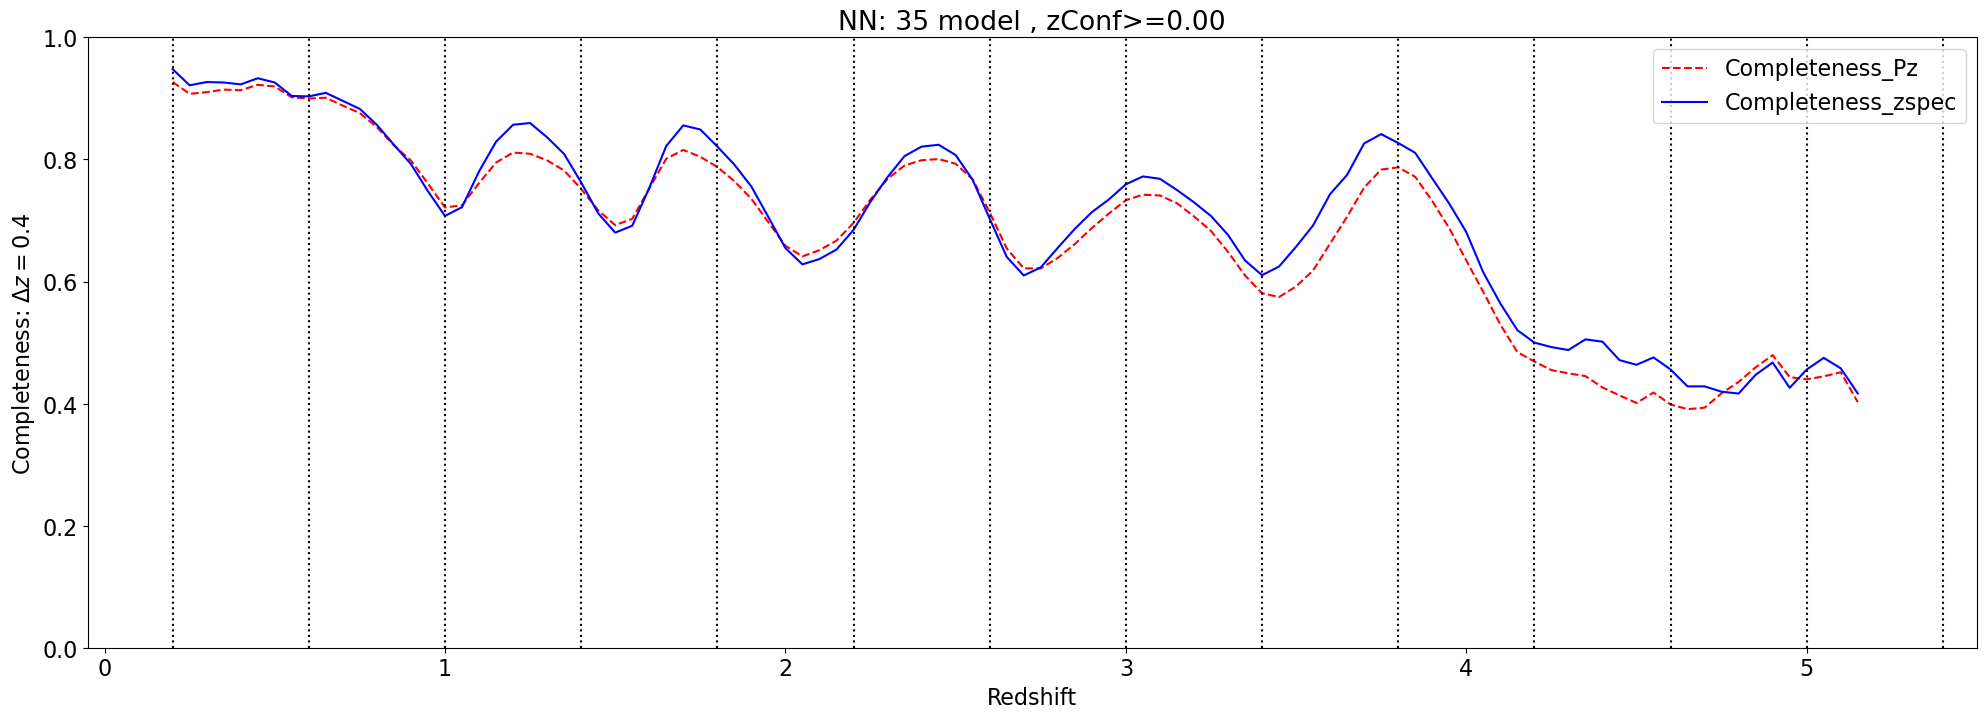

In [26]:
dz = 0.4
zC = 0.0

ddm = dict()
df = result_35
ddm[35] = pd.Series(df.loc[:,df.columns[50:50+288]].values.flatten())

lcompl = [] 
df = result_35
for z in np.arange(0.2, 5.2, 0.05):
    lgs = [];      
    zz = z
    z1 = zz - dz/2
    z2 = zz + dz/2
    bs = [z1,z2]
    df12sp = df.loc[(df[f'Z']>=z1)&(df[f'Z']<z2),:]
    df12 = df.loc[(df[f'mode']>=z1)&(df[f'mode']<z2),:]

    dd = pd.Series(df12.loc[:,df12.columns[50:50+288]].values.flatten())
    dd0 = ddm[35]

    fdd = ((dd>=z1)&(dd<z2)).sum() / ((dd0>=z1)&(dd0<z2)).sum()
    f12= ((df12sp['mode']>=z1)&(df12sp['mode']<z2)).sum() / df12sp['mode'].shape[0]
    lcompl.append([z,z1,z2,fdd,f12])
    lgs.append(f'model={35} zC>={zC:.2f}, k+{z - dz/2:.2f}<=zsp<{z + dz/2:.2f}+k')        

compl = pd.DataFrame(lcompl, columns=['z','z1','z2','Completeness_Pz','Completeness_zspec'])
fig, axs = plt.subplots(1, 1, figsize=(20, 7)); #ax = axs.flat
fig.tight_layout()
compl.plot(x='z', y='Completeness_Pz', color='red', linestyle='--', ax=axs)
compl.plot(x='z', y='Completeness_zspec', color='blue', linestyle='-', ax=axs)
axs.set_xlabel('Redshift'); axs.set_ylabel('Completeness: $\Delta{}z=0.4$'); 
axs.set_xlim(-0.05,5.5); 
axs.set_ylim(0.0,1.0);
axs.set_title(f'NN: {35} model , zConf>={zC:.2f}')
for zzz in np.arange(0.2, 5.6, 0.4):
    axs.vlines(x=zzz, ymin=0, ymax=1, linestyle=':', color='black')

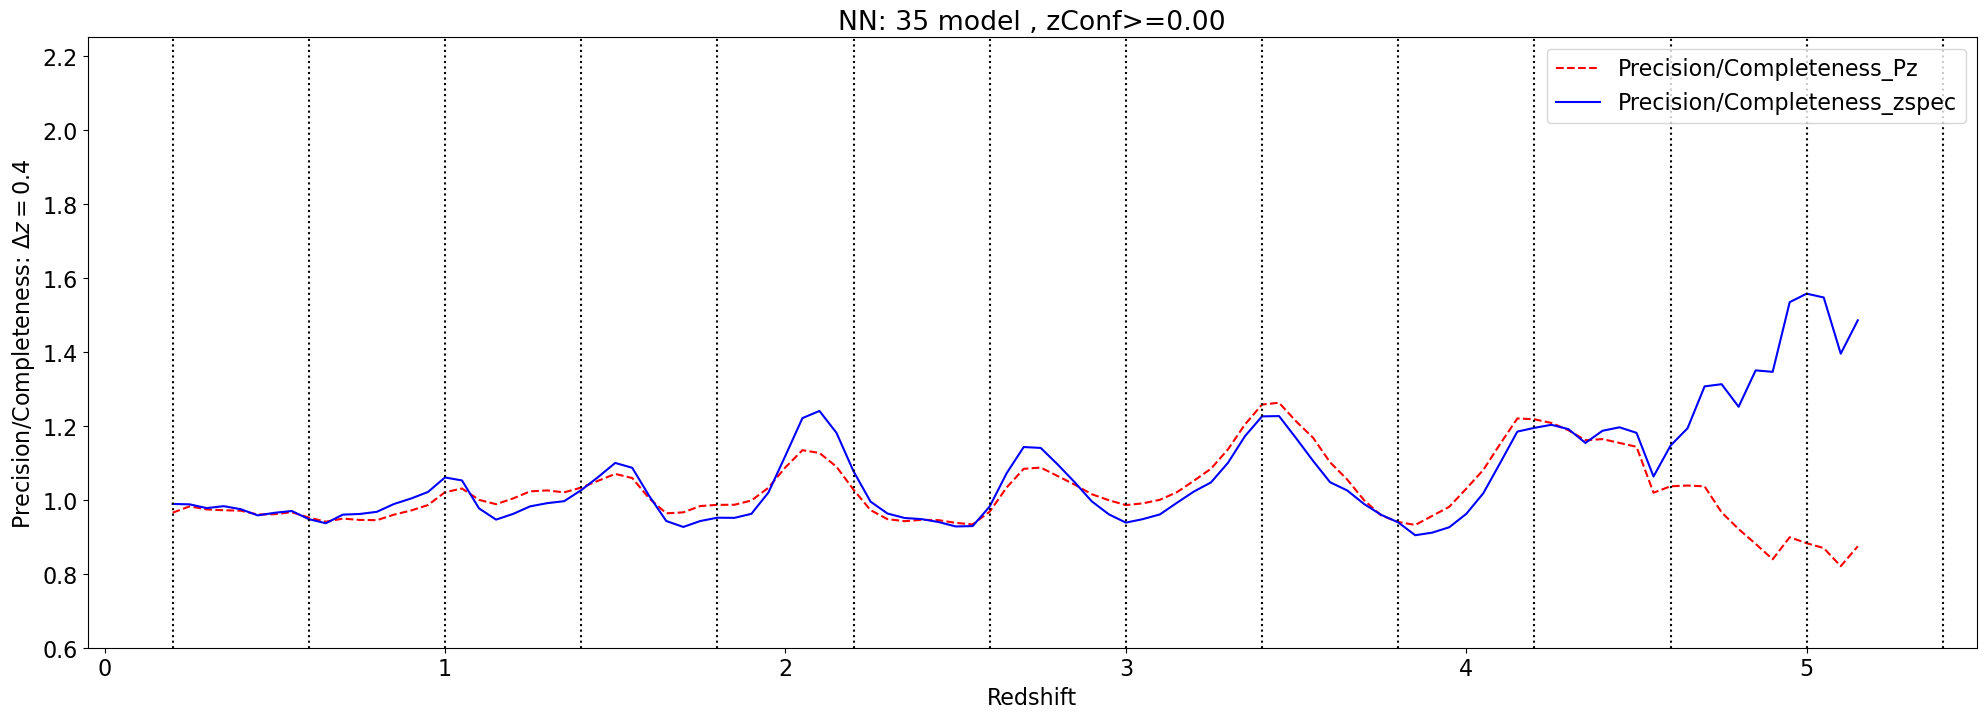

In [27]:
dz = 0.4
zC = 0.0

ddm = dict()
for mo in [35,20]:
    df = result_35
    ddm[35] = pd.Series(df.loc[:,df.columns[50:50+288]].values.flatten())

lprec = []; lcompl = []; lcoef = [] 
df = result_35
for z in np.arange(0.2, 5.2, 0.05):
    zz = z
    z1 = zz - dz/2
    z2 = zz + dz/2
    bs = [z1,z2]

    df12sp = df.loc[(df[f'Z']>=z1)&(df[f'Z']<z2),:]
    df12 = df.loc[(df[f'mode']>=z1)&(df[f'mode']<z2),:]
    dd = pd.Series(df12.loc[:,df12.columns[50:50+288]].values.flatten())
    dd0 = ddm[35]    
    fddp = ((dd>=z1)&(dd<z2)).sum()/dd.shape[0]
    f12p = ((df12['Z']>=z1)&(df12['Z']<z2)).sum()/ df12['Z'].shape[0]
    fddc = ((dd>=z1)&(dd<z2)).sum() / ((dd0>=z1)&(dd0<z2)).sum()
    f12c= ((df12sp[f'mode']>=z1)&(df12sp[f'mode']<z2)).sum() / df12sp[f'mode'].shape[0]
    lprec.append([z,z1,z2,fddp,f12p])
    lcompl.append([z,z1,z2,fddc,f12c])
    lcoef.append([z,z1,z2,fddp/fddc,f12p/f12c])

prec = pd.DataFrame(lprec, columns=['z','z1','z2','Precision_Pz','Precision_zspec'])
compl= pd.DataFrame(lcompl, columns=['z','z1','z2','Completeness_Pz','Completeness_zspec'])
coef = pd.DataFrame(lcoef, columns=['z','z1','z2','Precision/Completeness_Pz','Precision/Completeness_zspec'])

fig, axs = plt.subplots(1, 1, figsize=(20, 7)); #ax = axs.flat
fig.tight_layout()
coef.plot(x='z', y='Precision/Completeness_Pz', color='red', linestyle='--', ax=axs)
coef.plot(x='z', y='Precision/Completeness_zspec', color='blue', linestyle='-', ax=axs)
axs.set_xlabel('Redshift'); axs.set_ylabel('Precision/Completeness: $\Delta{}z=0.4$'); 
axs.set_xlim(-0.05,5.5); 
axs.set_ylim(0.6,2.25);
axs.set_title(f'NN: {35} model , zConf>={zC:.2f}')
for zzz in np.arange(0.2, 5.6, 0.4):
    axs.vlines(x=zzz, ymin=0, ymax=2.5, linestyle=':', color='black')

In [28]:
result_35.to_csv('35_main.csv', index=False)

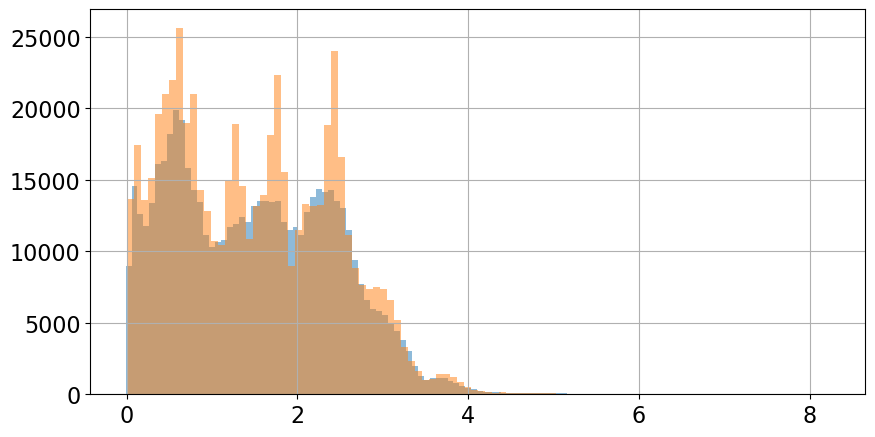

In [29]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 5))
plt.grid()

plt.hist(result_35['Z'], bins=100, alpha=0.5)
plt.hist(result_35['mode'], bins=100, alpha=0.5);

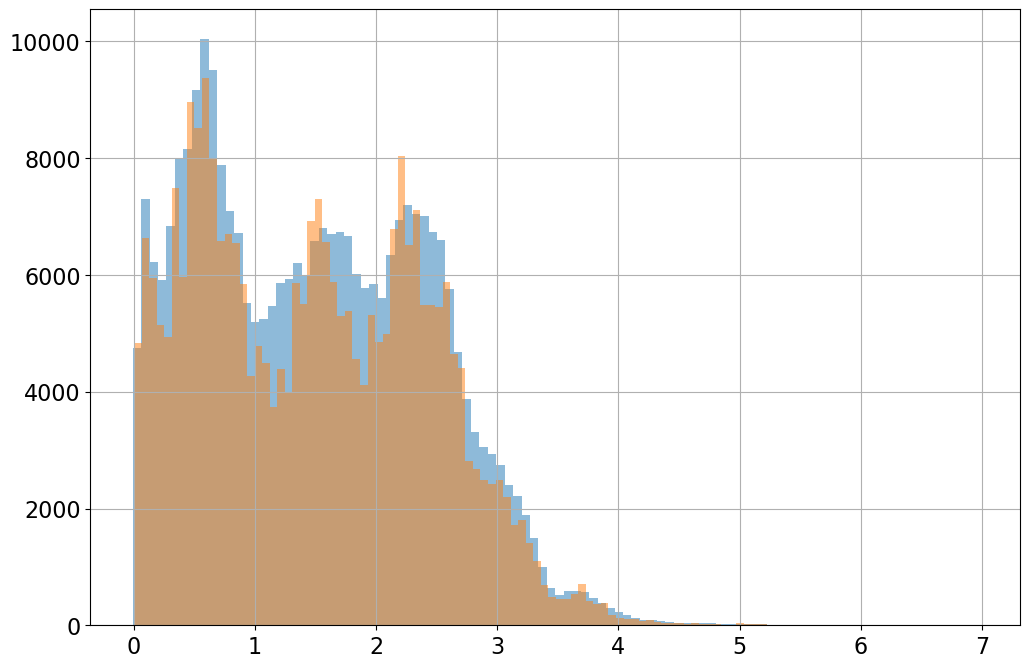

In [30]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 8))
plt.grid()

rf = pd.read_csv(f'{data_dir}/train_20_01.csv')
plt.hist(rf['Z'], bins=100, alpha=0.5)
plt.hist(rf['max35_z'], bins=100, alpha=0.5);

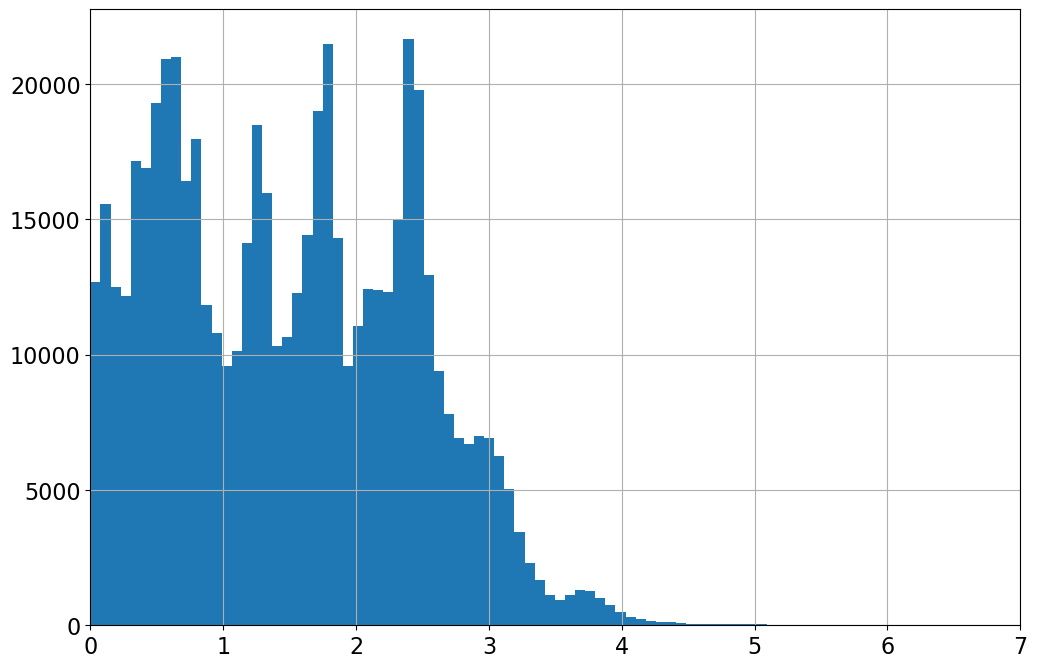

In [31]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 8))
plt.xlim(0, 7)
plt.grid()

plt.hist(
    result_35[result_35.columns[18: 18+15]].values.reshape(-1), bins=200,
    weights=result_35[result_35.columns[3: 3+15]].values.reshape(-1)
);

In [32]:
s82x = pd.read_csv(f'{data_dir}/S82X_35.csv')

In [33]:
s82x

,Unnamed: 0,RA_fin,DEC_fin,S82X_zsp,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,...,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x135_z_max
0,21,22.471667,-0.517429,0.487789,22.257399,21.698793,21.377648,20.672647,20.350846,21.443231,...,21.191457,20.777967,19.850765,0.413490,1.340692,0.927202,0.442952,0.209739,0.407382,0.508000
1,24,22.585373,-0.435827,0.977451,23.356672,22.089048,21.832145,22.017582,21.213080,23.413844,...,21.932744,21.810291,21.329032,0.122452,0.603712,0.481259,0.214879,-0.156372,-0.378195,0.898000
2,30,22.348276,-0.182006,1.350327,25.145797,23.244971,22.492633,21.881432,21.195992,24.761030,...,23.436966,22.163893,21.070665,1.273074,2.366301,1.093228,-0.213800,0.123743,-0.024809,0.910671
3,48,43.793337,-0.151334,0.183141,22.309840,21.068373,20.170029,19.724629,19.263227,19.907023,...,19.100066,18.025972,17.306609,1.074094,1.793457,0.719364,0.434409,0.554410,0.376099,0.274101
4,50,44.214102,-0.064564,0.394078,21.843174,21.329809,20.895795,20.516993,19.959325,21.862002,...,20.599412,19.841868,19.036888,0.757543,1.562524,0.804981,0.466852,0.005847,0.161877,0.410002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2021,45.955102,-1.103273,0.013631,19.610489,17.612889,16.532711,16.003806,15.386370,15.357764,...,13.531663,12.545563,11.758791,0.986099,1.772872,0.786773,0.057020,-0.058567,0.163999,0.008438
487,2028,45.436714,-0.735176,0.383317,19.790539,19.563522,19.545060,19.424591,18.984971,19.748191,...,19.799636,19.543130,18.979216,0.256506,0.820420,0.563914,-0.290921,-0.099805,-0.270140,0.374694
488,2033,45.110028,-0.638034,1.449859,20.348796,19.974922,19.823311,19.646700,19.591880,20.286120,...,20.115865,19.776698,19.624297,0.339167,0.491568,0.152401,-0.160429,0.050932,-0.283687,1.491000
489,2038,45.172941,-0.463517,0.230023,21.138951,20.504560,19.734648,19.326918,19.166702,20.747884,...,19.400922,18.600771,18.019360,0.800151,1.381562,0.581411,0.147640,0.072876,0.096839,0.240094


In [50]:
s82x_result_01 = ens_35_01.predict(s82x[features_35].values)
s82x_result_02 = ens_35_02.predict(s82x[features_35].values)

In [51]:
print(metrics.sigma_nmad(s82x['S82X_zsp'], (s82x_result_01['mode'] + s82x_result_02['mode']) / 2))
print(metrics.out_rate(s82x['S82X_zsp'], (s82x_result_01['mode'] + s82x_result_02['mode']) / 2))

0.034442046136924774
0.11608961303462322


In [46]:
print(metrics.sigma_nmad(s82x['S82X_zsp'], s82x['zoo_x135_z_max']))
print(metrics.out_rate(s82x['S82X_zsp'], s82x['zoo_x135_z_max']))

0.034245908165516675
0.11608961303462322


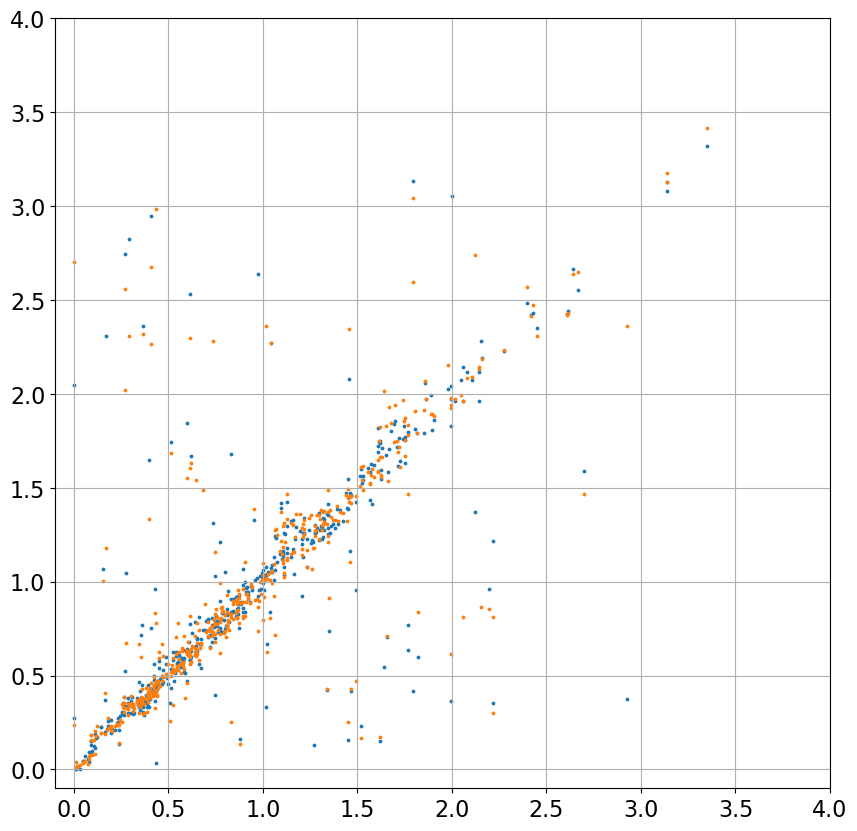

In [47]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(10, 10))
plt.xlim((-0.1, 4))
plt.ylim((-0.1, 4))
plt.grid()

plt.scatter(s82x['S82X_zsp'], s82x_result['mode'], s=3)
plt.scatter(s82x['S82X_zsp'], s82x['zoo_x135_z_max'], s=3)